## Imports

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import ta
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Conv1D, Flatten, RepeatVector, TimeDistributed, MaxPool1D
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams.update({'figure.figsize': (16, 9)})

## Load data

In [197]:
data = pd.read_csv('../data/processed/company_id_94_processed.csv', parse_dates=True)
data = data[['txn_date', 
             'open', 'high', 'low', 
             'close',
             'vol', 
#              'month', 
#              'day', 
#              'day_of_month'
            ]].sort_values(by='txn_date')
data['txn_date'] = pd.to_datetime(data['txn_date'])
# data = data[data['txn_date']< '2020-03-01']
data.set_index('txn_date', inplace=True, drop=True)
data['close_roc'] = data['close'].pct_change()
data['close_log_roc'] = np.log(1+data['close_roc'])
data['rsi'] = ta.momentum.RSIIndicator(close=data['close'], fillna=True).rsi()
data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
# data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
data['chaikin_money_flow'] = ta.volume.ChaikinMoneyFlowIndicator(high=data['high'], low=data['low'], close=data['close'], volume=data['vol'], fillna=True).chaikin_money_flow()
data.dropna(inplace=True)
# data = data.resample('W').mean()
data.drop(['open', 'high', 'low'], axis=1, inplace=True)
data.head()

,close,vol,close_roc,close_log_roc,rsi,macd_signal,chaikin_money_flow
txn_date,,,,,,,
1999-01-11,58.3,0.0,0.003442,0.003436,100.000000,0.003191,0.0
1999-01-12,58.5,0.0,0.003431,0.003425,100.000000,0.011398,0.0
1999-01-13,58.6,0.0,0.001709,0.001708,100.000000,0.023889,0.0
1999-01-14,58.8,0.0,0.003413,0.003407,100.000000,0.041546,0.0
1999-01-23,58.7,0.0,-0.001701,-0.001702,85.310605,0.059825,0.0


<AxesSubplot:>

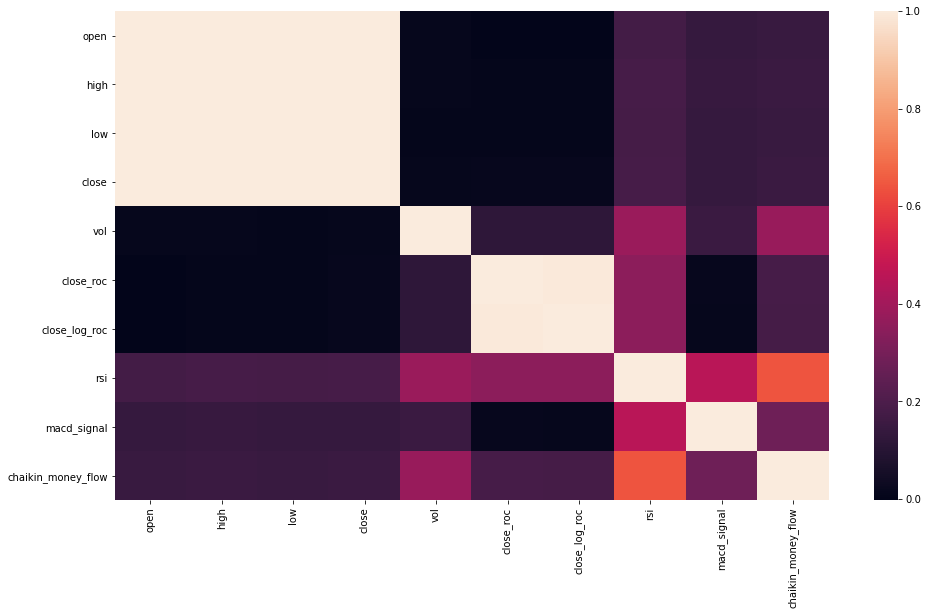

In [190]:
corr = data.corr()
sns.heatmap(corr)

## Preprocessing

In [3]:
# data.info()

In [4]:
# data.describe()

In [5]:
# min(data.index), max(data.index), data.shape[0]

In [6]:
# data['chaikin_money_flow'].plot()
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend(['Close Price'])
# plt.show()

In [7]:
# data['close_roc'].plot()
# plt.xlabel('Date')
# plt.ylabel('Close Price Rate Of Change')
# plt.show()

In [8]:
# data['vol'].plot()
# plt.xlabel('Date')
# plt.ylabel('Trade Volume')
# plt.show()

In [9]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [110]:
def custom_ts_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [111]:
def preprocessing(x, y):
    x_scaler = MinMaxScaler(feature_range=(-1,1))
    y_scaler = MinMaxScaler(feature_range=(-1,1))
    data_x = x_scaler.fit_transform(x)
    data_y = y_scaler.fit_transform(y)
    return (x_scaler, y_scaler, data_x, data_y)

In [127]:
def split_data(window, data_x, data_y, size=0.8, horizon=5):
    TRAIN_SPLIT = int(len(data_x)*size)
    x_train_multi, y_train_multi = custom_ts_data_prep(data_x, data_y, 0, TRAIN_SPLIT, window, horizon)
    x_val_multi, y_val_multi= custom_ts_data_prep(data_x, data_y, TRAIN_SPLIT, None, window, horizon)
    split = int(len(x_val_multi)*0.5)
#     x_val_multi, y_val_multi, x_test_multi, y_test_multi = x_val_multi[: split], y_val_multi[:split], x_val_multi[:-split], y_val_multi[:-split]
    assert(x_train_multi.shape[0]  == y_train_multi.shape[0])
    assert(x_val_multi.shape[0]  == y_val_multi.shape[0])
    return x_train_multi, y_train_multi, x_val_multi[: split], y_val_multi[:split], x_val_multi[:-split], y_val_multi[:-split],split

In [165]:
def prep_data(train_data, val_data):
    BATCH_SIZE = 128
    BUFFER_SIZE = 150
#     print(train_data[0].shape, val_data[0].shape)
#     print(train_data[1].shape, val_data[1].shape)
    train_data = tf.data.Dataset.from_tensor_slices(train_data)
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data = tf.data.Dataset.from_tensor_slices(val_data)
    val_data = val_data.batch(BATCH_SIZE).repeat()
    return (train_data, val_data)

In [114]:
def show_model_loss_plot(history, title=''):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss ' + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
#     plt.rcParams["figure.figsize"] = [16,9]
    plt.show()

In [124]:
def process(scaler, y_val_multi, 
            y_test_multi, 
            result_inv_trans,
            data, split,into=0):
    a = pd.DataFrame([scaler.inverse_transform(y[0].reshape(-1,1))[0][0] 
                      for y in y_val_multi], index=np.array(data.index)[-2*split:-split])
    b = pd.DataFrame([scaler.inverse_transform(y[0].reshape(-1,1))[0][0] 
                      for y in y_test_multi], index=data[-len(y_test_multi):].index)
    c = pd.DataFrame([scaler.inverse_transform(np.array(y[into]).reshape(-1,1))[0][0] 
                      for y in result_inv_trans], index=data[-len(result_inv_trans):].index)
    return a, b, c

In [116]:
def show_actual_vs_predicted_plot(a, b, c, title=''):    
    plt.plot(a )
    plt.plot(b)
    plt.plot(c)
    plt.title("Actual vs Predicted " + title)
    plt.ylabel("Price Rate of Change")
    plt.legend(('val','Actual','predicted'))
    plt.show()

In [169]:
def train_model(model, train_data, val_data, model_path,
                epochs=100, steps_per_epoch=100,
               validation_steps=50, verbose=1, callbacks= None):
    if callbacks == None:
        callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, patience=5,
                                                     verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',
                                                                  save_best_only=True, 
                                                                  mode='min',
                                                                  verbose=0)]
    
    history = model.fit(train_data, epochs=epochs,
                        steps_per_epoch=steps_per_epoch,validation_data=val_data, 
                        validation_steps=validation_steps, verbose =verbose,
                        callbacks=callbacks)
    return history

In [193]:
def lifecycle(data, model_type='lstm', window=22, output='close', horizon=1, into=0):
    x_scaler, y_scaler,data_x, data_y = preprocessing(data, data[[output]])
    x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_test_multi, y_test_multi, split = split_data(window, data_x, data_y, 0.7, horizon=horizon)
    train_data, val_data = prep_data((x_train_multi, y_train_multi), (x_val_multi, y_val_multi))
#     print(x_train_multi[0], y_train_multi[0])
    model = get_model(model_type, x_train_multi.shape[-2:], output=horizon)
    model_path = r'../models/{}_{}_{}_{}_{}.h5'.format(model_type, window, output, horizon, into)
    history = train_model(model, train_data, val_data, model_path)
    model = tf.keras.models.load_model(model_path)
    model.summary()
    result_inv_trans = model.predict(x_test_multi)
#     print(result_inv_trans[0], y_val_multi[0])
    a, b, c = process(y_scaler, y_val_multi, y_test_multi, result_inv_trans, data, split, into=into)
    timeseries_evaluation_metrics_func(b.values, c.values)
    title = '{} for {} Days'.format(model_type.upper(), window)
    show_model_loss_plot(history, title)
    show_actual_vs_predicted_plot(a, b, c, title)

In [194]:
def get_model(type, input_shape, optimizer='adam', loss='mse', output=1):
    model = None
    if type == 'lstm':
        model = Sequential([
            LSTM(40, input_shape=input_shape, return_sequences=True),
            LSTM(units=40,return_sequences=True),
            Dropout(0.1),
            LSTM(units=40,return_sequences=True),
            Dropout(0.1),
            LSTM(units=20),
            Dense(units=output)
        ])
    elif type == 'rnn':
            model = Sequential([
                SimpleRNN(50, input_shape=input_shape, return_sequences=True),
                Dropout(0.1),
                SimpleRNN(15, input_shape=input_shape, return_sequences=True),
                Dropout(0.1),
#                 SimpleRNN(50, input_shape=input_shape, return_sequences=True),
                Dense(output)
            ])
    elif type == 'gru':
        model = Sequential([
            GRU(50, input_shape=input_shape, return_sequences=True),
            Dropout(0.1),
            Dense(output)
        ])
    elif type == 'cnn':
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=input_shape, padding='valid'),
#             Conv1D(filters=64, kernel_size=3),
            MaxPool1D(pool_size=2),
            Dropout(0.2),
            Flatten(),
            Dense(output)
        ])
    else:
        None
    model.compile(optimizer=optimizer, loss=loss)
    return model

Epoch 1/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2893 - val_loss: 0.0281
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1653 - val_loss: 0.0017
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1217 - val_loss: 0.0061
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0962 - val_loss: 0.0015
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 1.3337e-04
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 6.7947e-04
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0582 - val_loss: 2.3625e-04
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 1.1927e-04
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 4.5047e-04
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - l

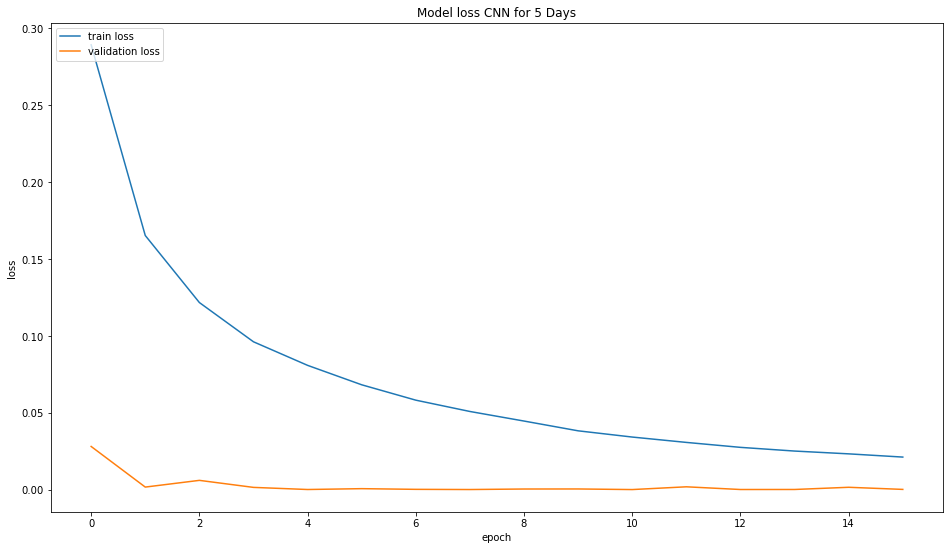

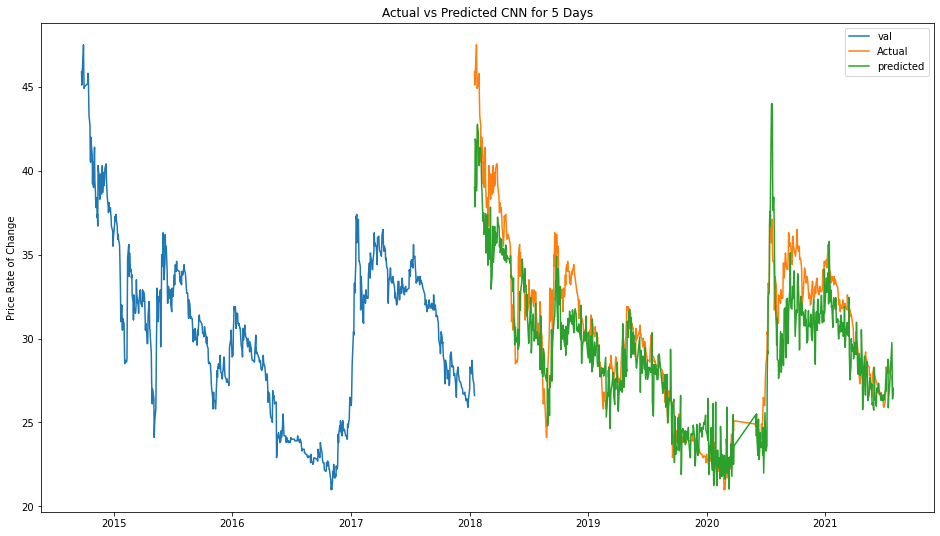

In [198]:
# lstm_model.compile(optimizer='adam', loss='mse')
lifecycle(data, 'cnn', 5)